In [1]:
import matplotlib 
import numpy as np
import pylab as plt
import os
%matplotlib inline

In [2]:
import numpy as np

def gaussian(t, t0, sigma, amp):
    return amp * np.exp(-0.5 * ((t - t0) / sigma) ** 2)

def truncated_normal(rng, mean, sd, low, high, size=None):
    """Simple rejection sampler for truncated normal."""
    if size is None:
        while True:
            x = rng.normal(mean, sd)
            if low <= x <= high:
                return x
    else:
        out = np.empty(size, dtype=float)
        i = 0
        while i < size:
            x = rng.normal(mean, sd, size=size - i)
            x = x[(x >= low) & (x <= high)]
            n = len(x)
            out[i:i+n] = x
            i += n
        return out

def make_pmt_waveform_controlled(
    n_samples=2000,
    dt=1e-7,
    amp_clip=(-0.5, 0.5),

    # noise kept small so it doesn't dominate minima
    baseline_sigma=0.003,
    baseline_offset_sigma=0.002,

    # MAIN pulse ToA fixed
    toa=0.6e-6,                 # 0.6 microseconds
    toa_jitter=0.0,             # set to 0.0 for "exactly .6"
    pulse_sigma_range=(1.5e-7, 6e-7),

    # amplitude distribution targeting abs(min) in ~[0, 0.05], leaning left
    main_amp_abs_low=0.002,
    main_amp_abs_high=0.05,
    main_amp_abs_mean=0.015,    # smaller mean => more weight near 0
    main_amp_abs_sd=0.012,

    # optional extra small pulses (afterpulses / multi-PE)
    extra_pulse_prob=0.35,
    extra_pulses_max=2,
    extra_amp_scale=0.6,
    extra_delay_range=(2e-7, 2.0e-6),

    add_undershoot=True,
    undershoot_frac=0.20,
    undershoot_delay_range=(3e-7, 1.2e-6),
    undershoot_sigma_mult=2.0,

    rng=None,
):
    rng = np.random.default_rng() if rng is None else rng
    t = np.arange(n_samples) * dt

    # baseline + noise
    y = rng.normal(0.0, baseline_sigma, size=n_samples)
    y += rng.normal(0.0, baseline_offset_sigma)

    # main pulse time: exactly toa if toa_jitter=0
    t0 = toa + rng.normal(0.0, toa_jitter)
    # keep it safely inside the record
    t0 = np.clip(t0, 10*dt, (n_samples-10)*dt)

    sigma0 = rng.uniform(pulse_sigma_range[0], pulse_sigma_range[1])

    # draw |amp| from truncated normal, then make it negative-going (typical)
    amp_abs = truncated_normal(
        rng,
        mean=main_amp_abs_mean,
        sd=main_amp_abs_sd,
        low=main_amp_abs_low,
        high=main_amp_abs_high
    )
    amp0 = -amp_abs
    y += gaussian(t, t0, sigma0, amp0)

    # undershoot (opposite sign)
    if add_undershoot:
        delay_u = rng.uniform(undershoot_delay_range[0], undershoot_delay_range[1])
        t1 = np.clip(t0 + delay_u, 10*dt, (n_samples-10)*dt)
        amp_u = -undershoot_frac * amp0  # opposite sign (since amp0 is negative)
        y += gaussian(t, t1, undershoot_sigma_mult * sigma0, amp_u)

    # optional extra small pulses
    if rng.random() < extra_pulse_prob:
        n_extra = rng.integers(1, extra_pulses_max + 1)
        for _ in range(n_extra):
            d = rng.uniform(extra_delay_range[0], extra_delay_range[1])
            te = np.clip(t0 + d, 10*dt, (n_samples-10)*dt)
            se = rng.uniform(pulse_sigma_range[0], pulse_sigma_range[1])
            ae = -extra_amp_scale * truncated_normal(
                rng,
                mean=main_amp_abs_mean,
                sd=main_amp_abs_sd,
                low=main_amp_abs_low,
                high=main_amp_abs_high
            )
            y += gaussian(t, te, se, ae)

    # clip to your ADC-ish range
    y = np.clip(y, amp_clip[0], amp_clip[1])
    return t, y


In [7]:
def read_waveforms_from_file(filepath, start_line):
    data = np.loadtxt(filepath, delimiter=',', skiprows=start_line-1, usecols=(0,1))

    waveforms = []
    prev_time = data[0,0]
    current_time_list = []
    current_val_list = []

    for t, v in data:
        if t < prev_time and current_time_list:
            waveforms.append((np.array(current_time_list), np.array(current_val_list)))
            current_time_list = []
            current_val_list = []

        current_time_list.append(t)
        current_val_list.append(v)
        prev_time = t

    if current_time_list:
        waveforms.append((np.array(current_time_list), np.array(current_val_list)))

    return waveforms

In [8]:
base_path = "/tmp/pmt_synth_data"
start_line = 4505

folder_waveforms = {}
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)
    if not (os.path.isdir(folder_path) and folder_name.startswith('900V_210p13')):
        continue

    all_waveforms_in_folder = []
    
    for filename in sorted(os.listdir(folder_path)):
        if not filename.startswith('C2Trace'):
            continue
        
        filepath = os.path.join(folder_path, filename)
        waveforms = read_waveforms_from_file(filepath, start_line)
        all_waveforms_in_folder.extend(waveforms)
    folder_waveforms[folder_name] = all_waveforms_in_folder

In [9]:
cutoff = 1e7

filtered_waveforms = {}

for folder_name, waves in folder_waveforms.items():
    filtered_waveforms[folder_name] = [] 
    
    for time_vals, amplitude_vals in waves:
        time_vals = np.array(time_vals)
        amplitude_vals = np.array(amplitude_vals)

        dt = np.mean(np.diff(time_vals))
        fft_vals = np.fft.fft(amplitude_vals)
        freqs = np.fft.fftfreq(len(amplitude_vals), dt)

        filter_mask = np.abs(freqs) < cutoff
        fft_filtered = fft_vals * filter_mask

        amplitude_filtered = np.fft.ifft(fft_filtered).real
        
        filtered_waveforms[folder_name].append((time_vals, amplitude_filtered))


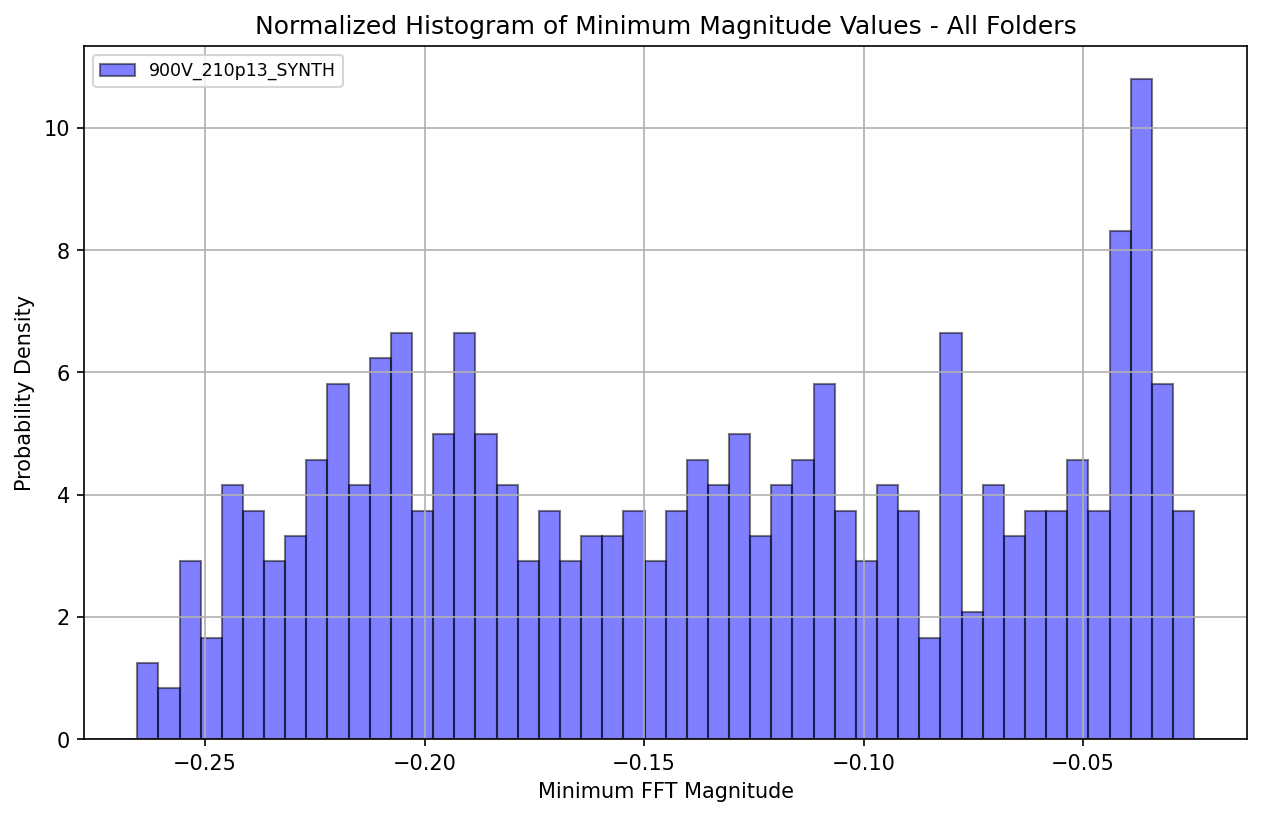

In [10]:
plt.figure(figsize=(10, 6), dpi=150)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan'] 
for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    results = []
    
    for time_arr, val_arr in waveforms:
        min_val = np.min(val_arr)   # minimum amplitude value of filtered waveform
        results.append(min_val)
        
    plt.hist(results, bins=50, alpha=0.5, density=True, color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Minimum FFT Magnitude')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of Minimum Magnitude Values - All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()


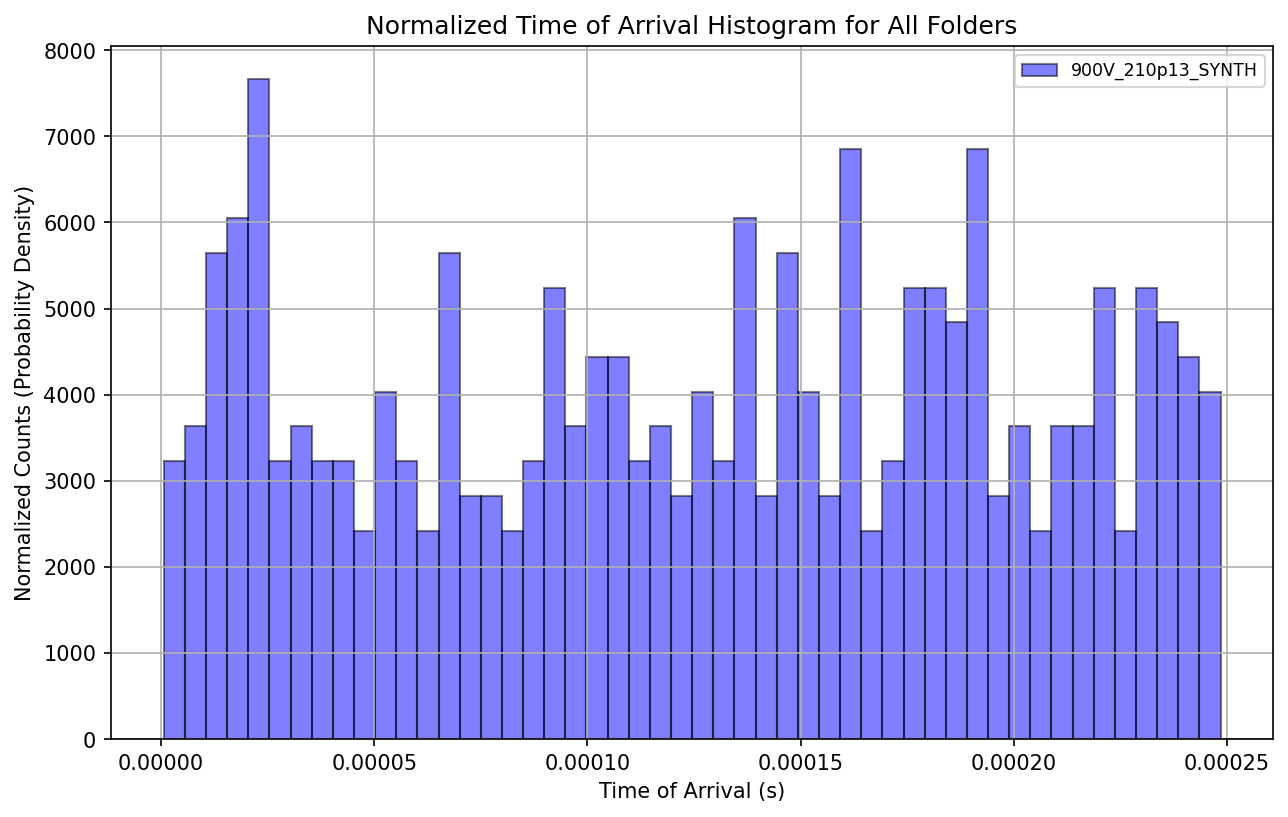

In [11]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    times_of_arrival = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]
        amplitude_vals = np.array(amplitude_vals)

        V_min = np.min(amplitude_vals)
        min_idx = np.argmin(amplitude_vals)
        threshold = V_min / 2

        crossing_idx = None
        for idx in range(min_idx - 1, 0, -1):
            if amplitude_vals[idx] > threshold and amplitude_vals[idx + 1] <= threshold:
                crossing_idx = idx
                break

        if crossing_idx is not None:
            t1, v1 = time_vals[crossing_idx], amplitude_vals[crossing_idx]
            t2, v2 = time_vals[crossing_idx + 1], amplitude_vals[crossing_idx + 1]
            slope = (v2 - v1) / (t2 - t1)
            t_cross = t1 + (threshold - v1) / slope
            times_of_arrival.append(t_cross)
        else:
            times_of_arrival.append(np.nan)

    times_of_arrival = np.array(times_of_arrival)
    valid_times = times_of_arrival[~np.isnan(times_of_arrival)]

    if len(valid_times) == 0:
        print(f"No valid times for folder {folder_name}")
        continue
    plt.hist(valid_times, bins=50, alpha=0.5, density=True,
             color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Time of Arrival (s)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Time of Arrival Histogram for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [6]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']
zero_threshold = 1e-4  # threshold to treat as zero crossing, adjust if needed

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    pulse_areas = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]  # normalize time start to zero
        amplitude_vals = np.array(amplitude_vals)

        # Find index of minimum amplitude (pulse minimum)
        min_idx = np.argmin(amplitude_vals)

        # Find zero crossing before min_idx (leading edge)
        leading_zero_idx = None
        for j in range(min_idx, 0, -1):
            if amplitude_vals[j] * amplitude_vals[j - 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                leading_zero_idx = j
                break

        # Find zero crossing after min_idx (trailing edge)
        trailing_zero_idx = None
        for j in range(min_idx, len(amplitude_vals) - 1):
            if amplitude_vals[j] * amplitude_vals[j + 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                trailing_zero_idx = j
                break

        # If both zero crossings found, integrate pulse area
        if leading_zero_idx is not None and trailing_zero_idx is not None and trailing_zero_idx > leading_zero_idx:
            idx_range = slice(leading_zero_idx, trailing_zero_idx + 1)
            area = np.trapz(amplitude_vals[idx_range], time_vals[idx_range])
            pulse_areas.append(area)
        else:
            # If zero crossings not found, skip this waveform or handle differently
            continue

    if len(pulse_areas) == 0:
        print(f"No valid pulse areas in folder {folder_name}")
        continue

    # Plot normalized histogram for this folder
    plt.hist(pulse_areas, bins=50, alpha=0.5, density=True,
             color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Pulse Area (Integral)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Pulse Area Distribution for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()


NameError: name 'filtered_waveforms' is not defined

<Figure size 1500x900 with 0 Axes>

In [7]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(12, 7), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    if len(waveforms) == 0:
        continue

    min_time = min(w[0][0] for w in waveforms)
    max_time = max(w[0][-1] for w in waveforms)

    common_time = np.linspace(min_time, max_time, 1000)

    interpolated_amps = []
    for time_vals, amp_vals in waveforms:
        time_vals = np.array(time_vals)
        amp_vals = np.array(amp_vals)
        interp_amp = np.interp(common_time, time_vals, amp_vals)
        interpolated_amps.append(interp_amp)

    avg_amp = np.mean(interpolated_amps, axis=0)

    plt.plot(common_time, avg_amp, color=colors[i % len(colors)], label=folder_name)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Average Waveforms per Folder')
plt.grid(True)
plt.legend(fontsize='small')
plt.show()


NameError: name 'filtered_waveforms' is not defined

<Figure size 1800x1050 with 0 Axes>

In [ ]:
cutoff = 2e7

filtered_waveforms = {}

for folder_name, waves in folder_waveforms.items():
    filtered_waveforms[folder_name] = [] 
    
    for time_vals, amplitude_vals in waves:
        time_vals = np.array(time_vals)
        amplitude_vals = np.array(amplitude_vals)

        dt = np.mean(np.diff(time_vals))
        fft_vals = np.fft.fft(amplitude_vals)
        freqs = np.fft.fftfreq(len(amplitude_vals), dt)

        filter_mask = np.abs(freqs) < cutoff
        fft_filtered = fft_vals * filter_mask

        amplitude_filtered = np.fft.ifft(fft_filtered).real
        
        filtered_waveforms[folder_name].append((time_vals, amplitude_filtered))


In [ ]:
plt.figure(figsize=(10, 6), dpi=150)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan'] 
for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    if count >= 3:
        break
    results = []
    
    for time_arr, val_arr in waveforms:
        min_val = np.min(val_arr)   # minimum amplitude value of filtered waveform
        results.append(min_val)
        
    plt.hist(results, bins=50, alpha=0.5, density=True, color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Minimum FFT Magnitude')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of Minimum Magnitude Values - All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    times_of_arrival = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]
        amplitude_vals = np.array(amplitude_vals)

        V_min = np.min(amplitude_vals)
        min_idx = np.argmin(amplitude_vals)
        threshold = V_min / 2

        crossing_idx = None
        for idx in range(min_idx - 1, 0, -1):
            if amplitude_vals[idx] > threshold and amplitude_vals[idx + 1] <= threshold:
                crossing_idx = idx
                break

        if crossing_idx is not None:
            t1, v1 = time_vals[crossing_idx], amplitude_vals[crossing_idx]
            t2, v2 = time_vals[crossing_idx + 1], amplitude_vals[crossing_idx + 1]
            slope = (v2 - v1) / (t2 - t1)
            t_cross = t1 + (threshold - v1) / slope
            times_of_arrival.append(t_cross)
        else:
            times_of_arrival.append(np.nan)

    times_of_arrival = np.array(times_of_arrival)
    valid_times = times_of_arrival[~np.isnan(times_of_arrival)]
    if len(valid_times) == 0:
        print(f"No valid times for folder {folder_name}")
        continue
        
    mu = np.mean(valid_times)
    sigma = np.std(valid_times)
    print(f"Folder: {folder_name}")
    print(f"Mean arrival time (μ): {mu:.3e} s")
    print(f"Standard deviation (σ): {sigma:.3e} s\n")

    
    plt.hist(valid_times, bins=50, alpha=0.5, density=True,
             color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Time of Arrival (s)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Time of Arrival Histogram for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']
zero_threshold = 1e-4  # threshold to treat as zero crossing, adjust if needed

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    pulse_areas = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]  # normalize time start to zero
        amplitude_vals = np.array(amplitude_vals)

        # Find index of minimum amplitude (pulse minimum)
        min_idx = np.argmin(amplitude_vals)

        # Find zero crossing before min_idx (leading edge)
        leading_zero_idx = None
        for j in range(min_idx, 0, -1):
            if amplitude_vals[j] * amplitude_vals[j - 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                leading_zero_idx = j
                break

        # Find zero crossing after min_idx (trailing edge)
        trailing_zero_idx = None
        for j in range(min_idx, len(amplitude_vals) - 1):
            if amplitude_vals[j] * amplitude_vals[j + 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                trailing_zero_idx = j
                break
                
        # If both zero crossings found, integrate pulse area
        if leading_zero_idx is not None and trailing_zero_idx is not None and trailing_zero_idx > leading_zero_idx:
            idx_range = slice(leading_zero_idx, trailing_zero_idx + 1)
            area = np.trapz(amplitude_vals[idx_range], time_vals[idx_range])
            pulse_areas.append(area)
        else:
            # If zero crossings not found, skip this waveform or handle differently
            continue

    if len(pulse_areas) == 0:
        print(f"No valid pulse areas in folder {folder_name}")
        continue

    # Plot normalized histogram for this folder
    plt.hist(pulse_areas, bins=50, alpha=0.5, density=True,
             color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Pulse Area (Integral)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Pulse Area Distribution for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()


In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(12, 7), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    if len(waveforms) == 0:
        continue

    min_time = min(w[0][0] for w in waveforms)
    max_time = max(w[0][-1] for w in waveforms)

    common_time = np.linspace(min_time, max_time, 1000)

    interpolated_amps = []
    for time_vals, amp_vals in waveforms:
        time_vals = np.array(time_vals)
        amp_vals = np.array(amp_vals)
        interp_amp = np.interp(common_time, time_vals, amp_vals)
        interpolated_amps.append(interp_amp)

    avg_amp = np.mean(interpolated_amps, axis=0)

    plt.plot(common_time, avg_amp, color=colors[i % len(colors)], label=folder_name)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Average Waveforms per Folder')
plt.grid(True)
plt.legend(fontsize='small')
plt.show()

In [ ]:
filtered_waveforms_cutoff = {}
for folder_name, waveforms in filtered_waveforms.items():
    times_of_arrival = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]
        amplitude_vals = np.array(amplitude_vals)

        V_min = np.min(amplitude_vals)
        min_idx = np.argmin(amplitude_vals)
        threshold = V_min / 2

        crossing_idx = None
        for idx in range(min_idx - 1, 0, -1):
            if amplitude_vals[idx] > threshold and amplitude_vals[idx + 1] <= threshold:
                crossing_idx = idx
                break

        if crossing_idx is not None:
            t1, v1 = time_vals[crossing_idx], amplitude_vals[crossing_idx]
            t2, v2 = time_vals[crossing_idx + 1], amplitude_vals[crossing_idx + 1]
            slope = (v2 - v1) / (t2 - t1)
            t_cross = t1 + (threshold - v1) / slope
        else:
            t_cross = np.nan
        
        times_of_arrival.append(t_cross)

    times_of_arrival = np.array(times_of_arrival)
    valid_times = times_of_arrival[~np.isnan(times_of_arrival)]

    if len(valid_times) == 0:
        print(f"No valid pulses in folder {folder_name}")
        filtered_waveforms_cutoff[folder_name] = []
        continue

    mu = np.mean(valid_times)
    sigma = np.std(valid_times)
    cutoff_time = mu + 2 * sigma

    filtered_waveforms_cutoff[folder_name] = []
    for (time_vals, amplitude_vals), t_arrival in zip(waveforms, times_of_arrival):
        if not np.isnan(t_arrival) and t_arrival <= cutoff_time:
            filtered_waveforms_cutoff[folder_name].append((time_vals, amplitude_vals))

    print(f"{folder_name}: kept {len(filtered_waveforms_cutoff[folder_name])} of {len(waveforms)} waveforms after cutoff")

In [ ]:
print(filtered_waveforms_cutoff)

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan'] 
for i, (folder_name, waveforms) in enumerate(filtered_waveforms_cutoff.items()):
    results = []
    
    for time_arr, val_arr in waveforms:
        min_val = np.min(val_arr)   
        results.append(min_val)
        
    plt.hist(results, bins=50, alpha=0.5, density=True, color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Minimum FFT Magnitude')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of Minimum Magnitude Values - All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan'] 
for i, (folder_name, waveforms) in enumerate(filtered_waveforms_cutoff.items()):
    results = []
    
    for time_arr, val_arr in waveforms:
        min_val = np.min(val_arr)   # minimum amplitude value of filtered waveform
        results.append(min_val)
        
    plt.hist(results, bins=50, alpha=0.5, density=True, color=colors[i % len(colors)],
             label=folder_name, edgecolor='black')

plt.xlabel('Minimum FFT Magnitude')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of Minimum Magnitude Values - All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms_cutoff.items()):
    times_of_arrival = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]
        amplitude_vals = np.array(amplitude_vals)

        V_min = np.min(amplitude_vals)
        min_idx = np.argmin(amplitude_vals)
        threshold = V_min / 2

        crossing_idx = None
        for idx in range(min_idx - 1, 0, -1):
            if amplitude_vals[idx] > threshold and amplitude_vals[idx + 1] <= threshold:
                crossing_idx = idx
                break

        if crossing_idx is not None:
            t1, v1 = time_vals[crossing_idx], amplitude_vals[crossing_idx]
            t2, v2 = time_vals[crossing_idx + 1], amplitude_vals[crossing_idx + 1]
            slope = (v2 - v1) / (t2 - t1)
            t_cross = t1 + (threshold - v1) / slope
            times_of_arrival.append(t_cross)
        else:
            times_of_arrival.append(np.nan)

    times_of_arrival = np.array(times_of_arrival)
    valid_times = times_of_arrival[~np.isnan(times_of_arrival)]
    if len(valid_times) == 0:
        print(f"No valid times for folder {folder_name}")
        continue

    plt.hist(valid_times, bins=50, alpha=0.5, density=True,
                 color=colors[i % len(colors)],
                 label=folder_name, edgecolor='black')

plt.xlabel('Time of Arrival (s)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Time of Arrival Histogram for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']
zero_threshold = 1e-4  # threshold to treat as zero crossing, adjust if needed

plt.figure(figsize=(10, 6), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms.items()):
    pulse_areas = []

    for time_vals, amplitude_vals in waveforms:
        time_vals = np.array(time_vals) - time_vals[0]  # normalize time start to zero
        amplitude_vals = np.array(amplitude_vals)

        # Find index of minimum amplitude (pulse minimum)
        min_idx = np.argmin(amplitude_vals)

        # Find zero crossing before min_idx (leading edge)
        leading_zero_idx = None
        for j in range(min_idx, 0, -1):
            if amplitude_vals[j] * amplitude_vals[j - 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                leading_zero_idx = j
                break

        # Find zero crossing after min_idx (trailing edge)
        trailing_zero_idx = None
        for j in range(min_idx, len(amplitude_vals) - 1):
            if amplitude_vals[j] * amplitude_vals[j + 1] < 0 or abs(amplitude_vals[j]) < zero_threshold:
                trailing_zero_idx = j
                break
                
        # If both zero crossings found, integrate pulse area
        if leading_zero_idx is not None and trailing_zero_idx is not None and trailing_zero_idx > leading_zero_idx:
            idx_range = slice(leading_zero_idx, trailing_zero_idx + 1)
            area = np.trapz(amplitude_vals[idx_range], time_vals[idx_range])
            pulse_areas.append(area)
        else:
            # If zero crossings not found, skip this waveform or handle differently
            continue

        if len(pulse_areas) == 0:
            print(f"No valid pulse areas in folder {folder_name}")
            continue

        # Plot normalized histogram for this folder
        plt.hist(pulse_areas, bins=50, alpha=0.5, density=True,
                 color=colors[i % len(colors)],
                 label=folder_name, edgecolor='black')

plt.xlabel('Pulse Area (Integral)')
plt.ylabel('Normalized Counts (Probability Density)')
plt.title('Normalized Pulse Area Distribution for All Folders')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()


In [ ]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

plt.figure(figsize=(12, 7), dpi=150)

for i, (folder_name, waveforms) in enumerate(filtered_waveforms_cutoff.items()):
    if len(waveforms) == 0:
        continue

    min_time = min(w[0][0] for w in waveforms)
    max_time = max(w[0][-1] for w in waveforms)

    common_time = np.linspace(min_time, max_time, 1000)

    interpolated_amps = []
    for time_vals, amp_vals in waveforms:
        time_vals = np.array(time_vals)
        amp_vals = np.array(amp_vals)
        interp_amp = np.interp(common_time, time_vals, amp_vals)
        interpolated_amps.append(interp_amp)

    avg_amp = np.mean(interpolated_amps, axis=0)

    plt.plot(common_time, avg_amp, color=colors[i % len(colors)], label=folder_name)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Average Waveforms per Folder')
plt.grid(True)
plt.legend(fontsize='small')
plt.show()